# ViT Small Pretrained on DINOv2 with registers 

## Augmentation: TrivialAugmentWide to 60000 samples



### import requirements

In [99]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, autoaugment
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

## Preparing Data

### Loading Original Dataset

In [100]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 415, 'val': 100}


### Counting Classes 

In [3]:
from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')

Class 0: 324 instances
Class 1: 156 instances


### Defining Augmentation Class 

In [ ]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class, transform=None, num_magnitude_bins=30):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_samples_per_class (int): Desired number of samples per class after augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = ImageFolder(root=root_dir)
        self.classes = self.dataset.classes
        self.num_samples_per_class = num_samples_per_class
        self.transform = transform
        self.augment_transform = transforms.Compose([
            autoaugment.TrivialAugmentWide(num_magnitude_bins=num_magnitude_bins),
            transforms.ToTensor(),
        ])
        self.class_samples = self._balance_classes()

    def _balance_classes(self):
        from collections import defaultdict
        class_indices = defaultdict(list)
        
        for idx, (_, class_id) in enumerate(self.dataset.samples):
            class_indices[class_id].append(idx)
        
        # Reduce or oversample class indices to match num_samples_per_class
        balanced_indices = []
        for indices in class_indices.values():
            if len(indices) >= self.num_samples_per_class:
                balanced_indices.extend(indices[:self.num_samples_per_class])
            else:
                # Oversample if there are fewer samples than desired
                oversampled_indices = indices * (self.num_samples_per_class // len(indices)) + indices[:self.num_samples_per_class % len(indices)]
                balanced_indices.extend(oversampled_indices)
                
        return balanced_indices

    def __len__(self):
        return len(self.class_samples)

    def __getitem__(self, idx):
        img, label = self.dataset[self.class_samples[idx]]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = self.augment_transform(img)
        return img, label
    
    def classes(self):
        return self.classes

### Creating Augmented Dataset

In [126]:
# Define Parameters
data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo2'
num_magnitude_bins = 100
num_samples_per_class = 30000

# Define any additional transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Creating datasets
datasets = {
    x: CustomAugmentedDataset(root_dir=os.path.join(data_path, x), transform=transform, num_magnitude_bins=num_magnitude_bins, num_samples_per_class=num_samples_per_class if x == 'train' else 3000) 
    for x in ['train', 'val']
}
print('Datasets created.')

# Creating dataloaders
batch_size = 32
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=0, shuffle=True if x == 'train' else False, drop_last=True)
    for x in ['train', 'val']
}
print('Dataloaders created.')
print('-' * 50)

# Show Classes
class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')
print('-' * 50)

# Show datasets length 
print('train dataset: ', len(datasets['train']))
print('val dataset: ', len(datasets['val']))

Datasets created.
Dataloaders created.
--------------------------------------------------
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
--------------------------------------------------
train dataset:  60000
val dataset:  6000


### Counting Classes

In [119]:
from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')

Class 1: 32984 instances
Class 0: 33000 instances


# Showing augmented data sample 

idx:  44187
idx type:  <class 'numpy.ndarray'>
image type:  <class 'torch.Tensor'>
label:  1
class name label:  Myxococcus


C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_13020\2271067175.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('idx: ', int(idx))
C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_13020\2271067175.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image, label = datasets['train'][int(idx)]


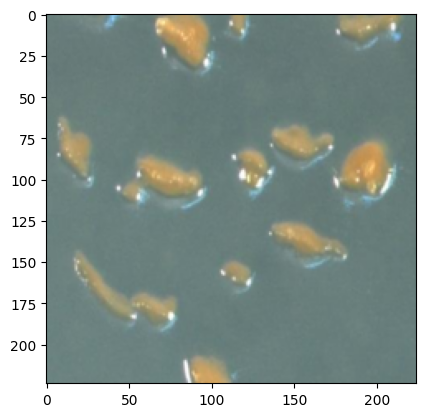

In [161]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, 60000, size=1)

print('idx: ', int(idx))
print('idx type: ', type(idx))
image, label = datasets['train'][int(idx)]    
print('image type: ', type(image))
print('label: ', label)
print('class name label: ', class_names[label])

# Convert torch tensor for plotting
image = image.permute(1,2,0)
plt.imshow(image)
plt.show()


# Load ViT pretrained on DINOv2 with registers model

In [102]:
# DINOv2
dinov2_vits14_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vitb14_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

# DINOv2 with registers
dinov2_vits14_reg_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_vitb14_reg_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
# dinov2_vitl14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
# dinov2_vitg14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')

Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main


# Fine-Tune model classifier and trainable parameters 

In [104]:
# Define model
model = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model.head  = nn.Sequential(
    nn.Linear(384, 2)
)
print(dinov2_vits14_reg_21M)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 125:
        break

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Defining Train function 

In [105]:
from datetime import datetime
from easydict import EasyDict


# train function 
def train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects / len(datasets[phase])

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print('-' * 50)

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

# Train ViT-s DINOv2 with registers 
---------------
## Hyperparameters:
### optimizer: Adam
### criterion: CrossEntropy
### Learning Rate: 0.001
### batch size: 32
### epoch: 50

In [106]:
# Defining hyperparameters
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')
optimizer = Adam(model.parameters(), lr=0.001)
model = model.to(device)
print(model)
print('-' * 50)

# train model
model, acc_lists, loss_lists = train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=50)

your device is cuda

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Iden

## Plot Results 

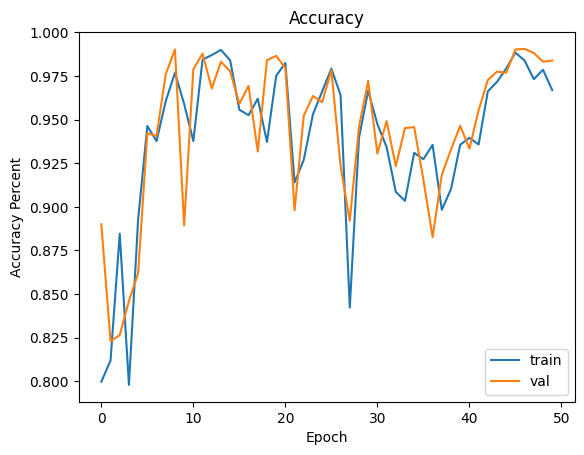

In [107]:
plt.plot([a.cpu() for a in acc_lists.train], label='train')
plt.plot([a.cpu() for a in acc_lists.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

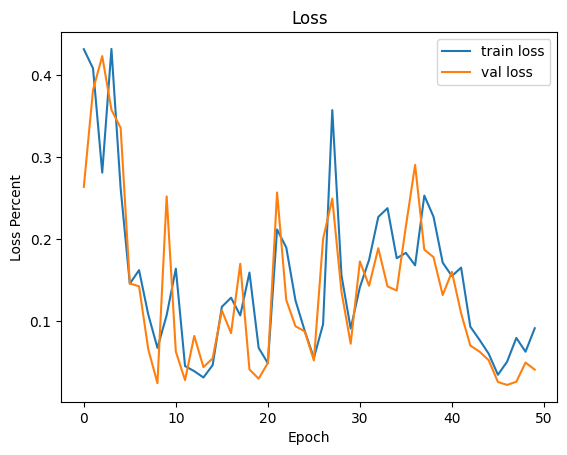

In [108]:
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()


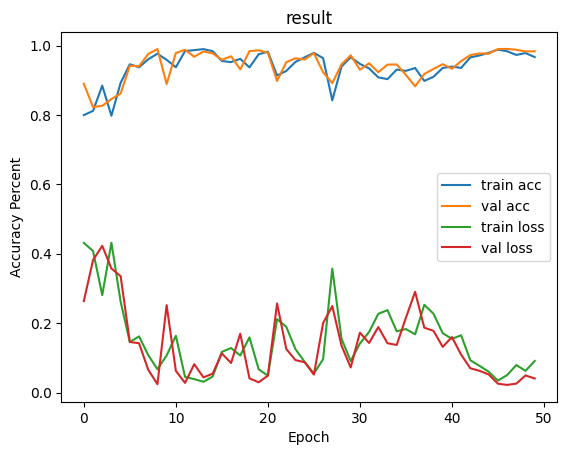

In [118]:
plt.plot([a.cpu() for a in acc_lists.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists.val], label='val acc')
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('result')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

## Save best model weights

In [ ]:
torch.save(model, 'models/model_2.pth')

## Visualize model predictions

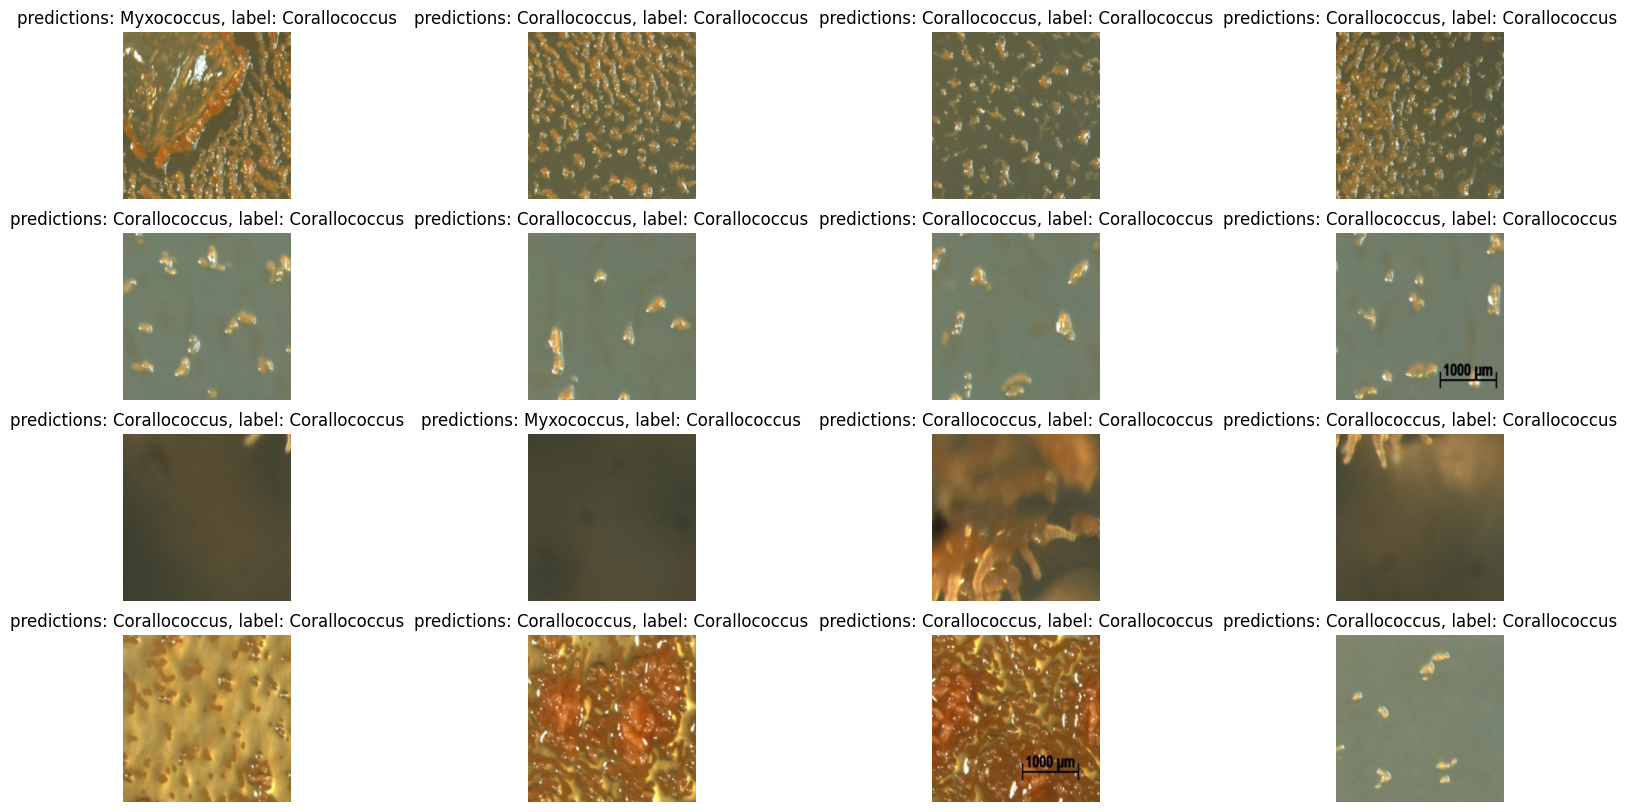

In [164]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                # img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break
    plt.savefig('vis.jpg')

model = torch.load('models/model_2.pth')
visualize_model(model)

# Fine-Tune model2 classifier and trainable parameters 

In [111]:
# Define model
model2 = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model2.head  = nn.Sequential(
    nn.Linear(384, 2)
)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model2.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 125:
        break

# Train ViT-s DINOv2 with registers 
---------------
## Hyperparameters:
### optimizer: Adam
### criterion: CrossEntropy
### Learning Rate: 0.0003
### batch size: 32
### epoch: 50

In [112]:
# Defining Hyperparameters 
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')
optimizer = Adam(model2.parameters(), lr=0.0003)
model2 = model2.to(device)
print(model2)
print('-' * 50)

# train model
model2, acc_lists2, loss_lists2 = train_model(model2, criterion, optimizer, dataloaders, datasets, epoch_num=50)

your device is cuda

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Iden

# Plot results

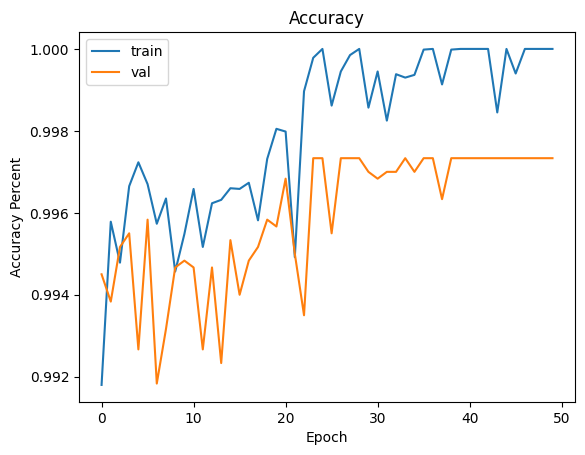

In [113]:
plt.plot([a.cpu() for a in acc_lists2.train], label='train')
plt.plot([a.cpu() for a in acc_lists2.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

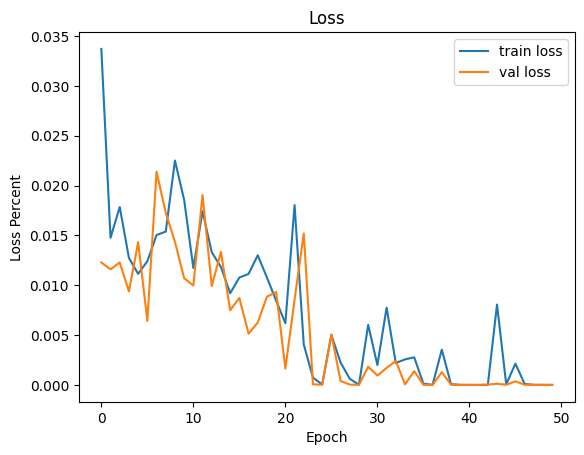

In [114]:
plt.plot([a for a in loss_lists2.train], label='train loss')
plt.plot([a for a in loss_lists2.val], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()


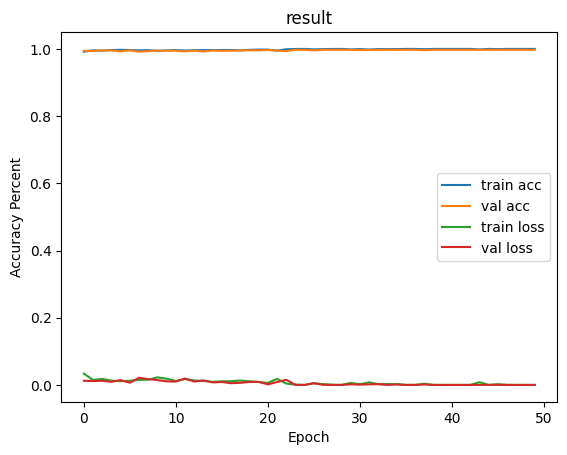

In [117]:
plt.plot([a.cpu() for a in acc_lists2.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists2.val], label='val acc')
plt.plot([a for a in loss_lists2.train], label='train loss')
plt.plot([a for a in loss_lists2.val], label='val loss')
plt.title('result')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

# Visualize model predictions

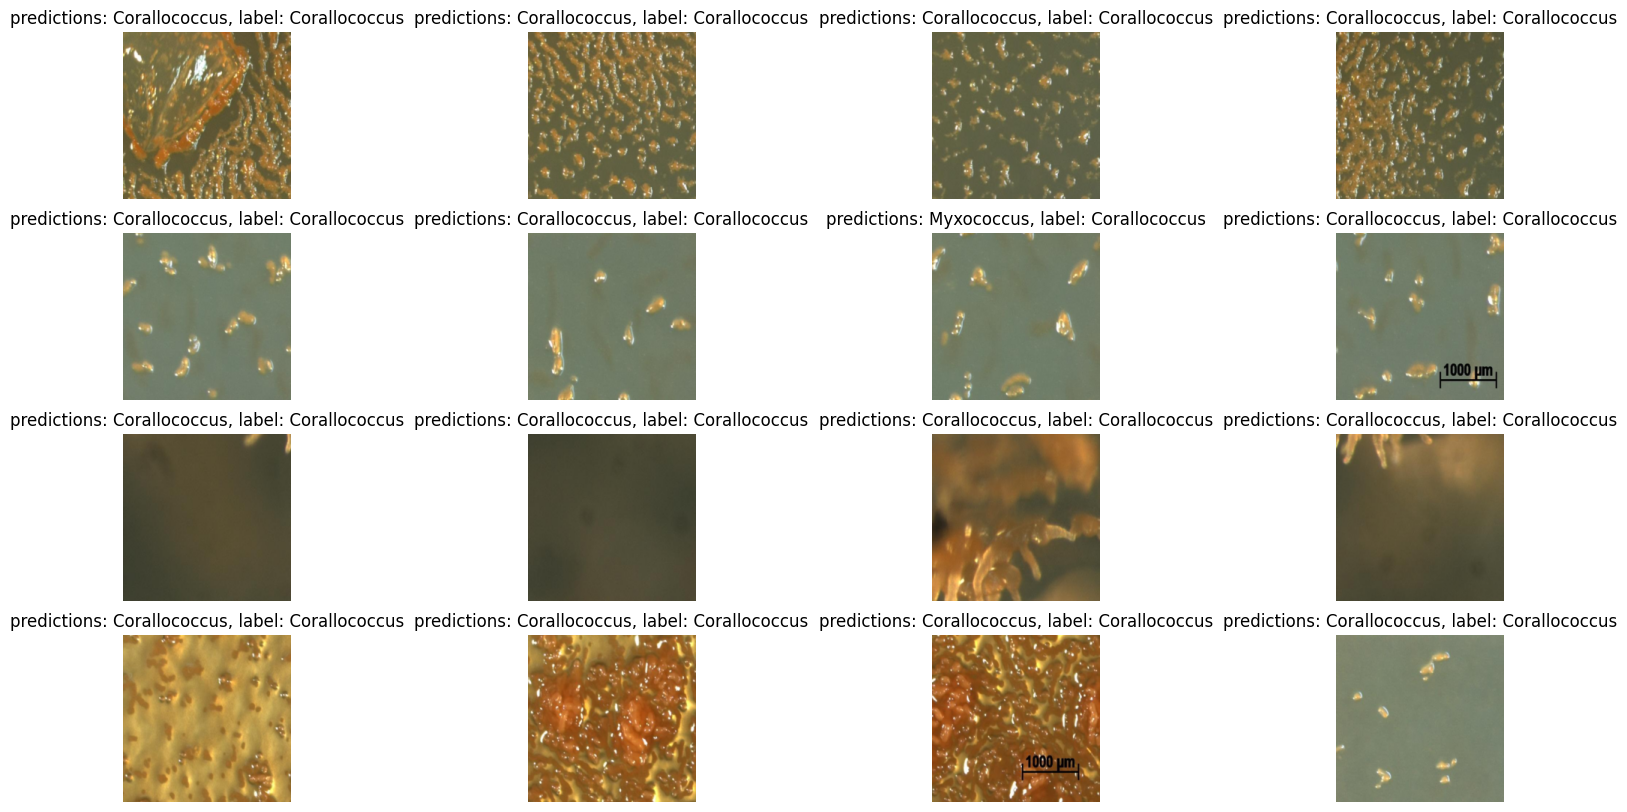

In [165]:
def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                # img = std * img + mean
                img = np.clip(img, 0, 1)
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
                if j == ncols - 1:
                    break
            if i == nrows - 1:
                break
    plt.savefig('vis.jpg')


visualize_model(model2)

## Save best model weights

In [116]:
torch.save(model, 'models/model_3.pth')